# NaiveBayes

In [110]:
import numpy as np
import pandas as pd
from plotnine import *
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics as mt

def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)
    
    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del tiempo a unix time stamp para medir la distancia de forma mas facil.
    df["date_departure_int"] = np.log10(pd.to_datetime(df["date"].map(str)+" "+df["departure_time"]).apply(lambda x: x.value))
    #df["date_departure_int"] = pd.to_datetime(df["date"].map(str)+" "+df["departure_time"], errors='coerce')
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [111]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
# Procesamos los datos con la funcion procesar_csv()
df = procesar_csv(df)
# transformamos los datos a binarios
df["Labels"] = np.where(df["noshow"] >= 4, 1,0)
# Definimos nuestra columna target
target = df['Labels']
# La eliminamos del dataframe
df.drop('noshow', axis=1, inplace=True)


#Columnas despues de la limpieza
df.columns

/home/matias/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10


Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr',
       'date_departure_int', 'Labels'],
      dtype='object')

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr,date_departure_int,Labels
0,8995,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,125,6,18.099599,1
1,7061,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,143,2,18.094508,0
2,8972,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,116,8,18.115589,1
3,6039,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,33,6,18.102437,1
4,7713,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,55,8,18.099124,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,6024,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,27,8,18.098888,1
999886,6669,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,57,10,18.093891,1
999887,9094,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,125,7,18.114587,1
999888,7704,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,126,5,18.093013,0


array([[<AxesSubplot:title={'center':'fligth_number'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'denied_boarding'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'pax_midlow'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'pax_high'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'pax_midhigh'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'pax_low'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'pax_freqflyer'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'group_bookings'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'out_of_stock'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'dom_cnx'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'int_cnx'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'p2p'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'capacity'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'bookings'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'origin_int'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'destination_int'}>]], dtype=object)

ValueError: hist method requires numerical or datetime columns, nothing to plot.

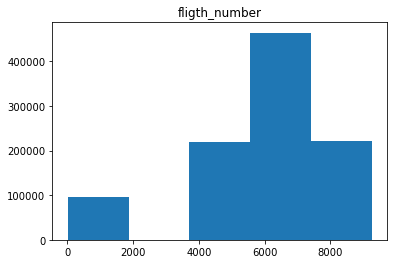

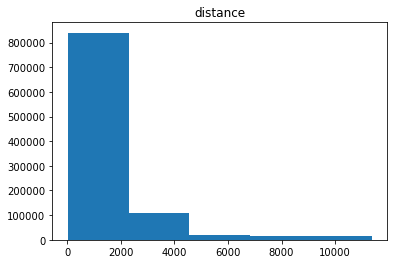

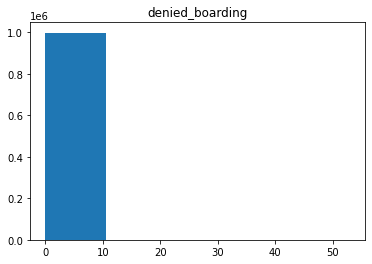

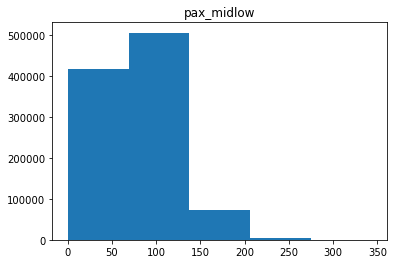

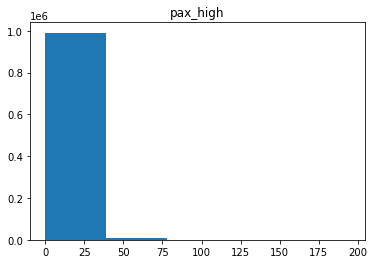

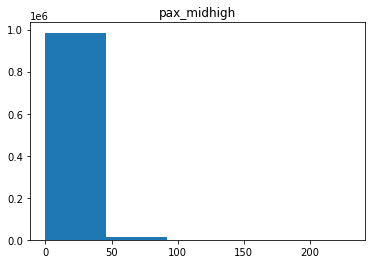

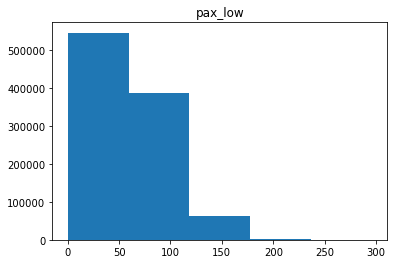

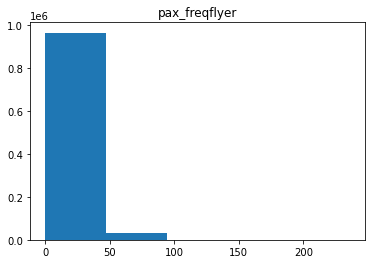

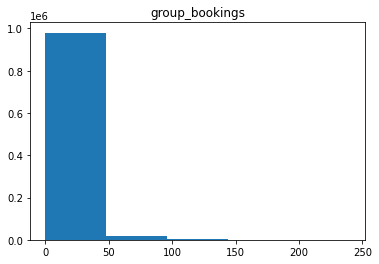

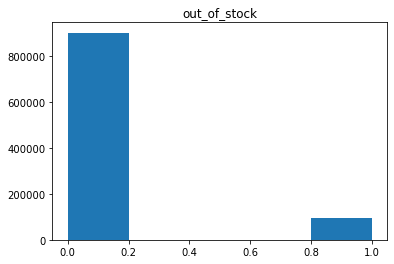

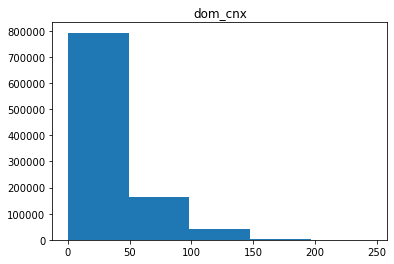

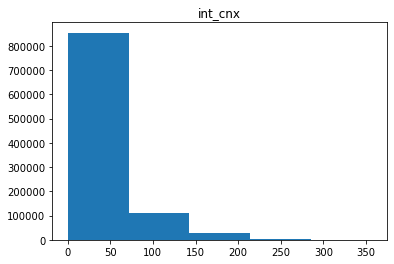

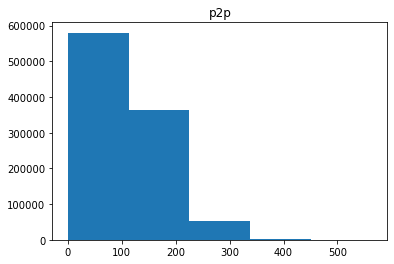

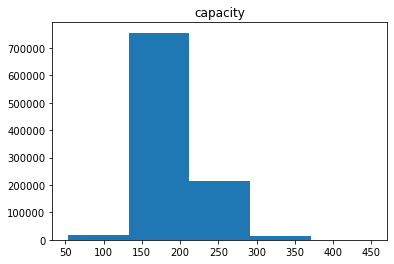

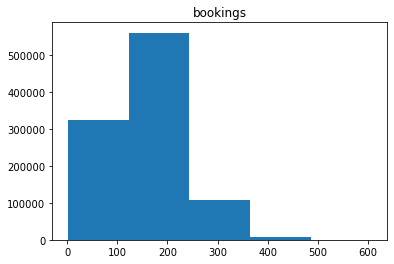

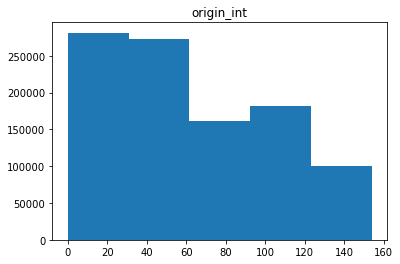

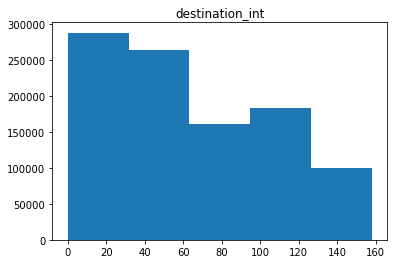

In [131]:
display(df)
for i in df.columns:
    display(df.hist(column = i, bins = 5, grid = False))

display(df)
for i in df.columns:
    display(df[i].value_counts())
    display(df[i].isna())

In [138]:
#Cree un objeto de KFold cross validation
for k in range (2,100, 5):
        kf = KFold(n_splits = k, shuffle = True, random_state = 0)

        #Cree arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).

        AccuracyTrain = np.zeros(k)
        AccuracyTest = np.zeros(k)

        RecallTrain = np.zeros(k)
        RecallTest = np.zeros(k)

        PrecisionTrain = np.zeros(k)
        PrecisionTest = np.zeros(k)

        F1Train = np.zeros(k)
        F1Test = np.zeros(k)

        #Cree el objeto de Naive Bayes que estime correspondiente, con el alpha deseado

        NB = GaussianNB(var_smoothing = 1)
        i=0
        #Aplique K-fold cross validation
        for train_index, test_index in kf.split(df):#Complete
                #extraiga los datos de entrenamiento y test
                trainData = df.iloc[train_index, :]
                testData = df.iloc[test_index, :]

                trainLabel = target.iloc[train_index]
                testLabel = target.iloc[test_index]

                #Entrene el modelo usando los datos de entrenamiento
                NB = NB.fit(trainData, trainLabel)

                #Prediga los valores de TrainData y calcule su error
                prediccion = NB.predict(trainData)
                F1Train[i] = mt.f1_score(trainLabel, prediccion)
                AccuracyTrain[i] = mt.accuracy_score(trainLabel, prediccion)
                RecallTrain[i] = mt.accuracy_score(trainLabel, prediccion)
                PrecisionTrain[i] = mt.accuracy_score(trainLabel, prediccion)

                #Prediga los valores de testData y calcule su error
                prediccion = NB.predict(testData)
                F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 1)
                #AccuracyTest[i] = mt.accuracy_score(trainLabel, prediccion)
                #RecallTest[i] = mt.accuracy_score(trainLabel, prediccion)
                #PrecisionTest[i] = mt.accuracy_score(trainLabel, prediccion)
                i+=1

        print("Numero iteraciónes: ", i)
        print("F1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
        print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())  

#print(f"Accuracy: {AccuracyTest.mean()}")
#print(f"Precicion para 1: {PrecisionTest.mean()}")
#print(f"Recall score: {RecallTest.mean()}")
#print(f"f1 Score: {f1Test.mean()}")

Numero iteraciónes:  2
F1-score modelo para training:  0.7919557724456461 +- 0.000402671908758645
F1-score modelo para test:  0.7919557724456461 +- 0.000402671908758645
Numero iteraciónes:  7
F1-score modelo para training:  0.7919558986706775 +- 9.813482097370188e-05
F1-score modelo para test:  0.7919556189068804 +- 0.0005886272153917783
Numero iteraciónes:  12
F1-score modelo para training:  0.7919559018330288 +- 7.641272045730289e-05
F1-score modelo para test:  0.7919553217249562 +- 0.0008406805840924773
Numero iteraciónes:  17
F1-score modelo para training:  0.7919559023344581 +- 7.218707067976149e-05
F1-score modelo para test:  0.7919547976603186 +- 0.0011550100526050247
Numero iteraciónes:  22
F1-score modelo para training:  0.7919559026290176 +- 6.977366037513774e-05
F1-score modelo para test:  0.7919541261427896 +- 0.0014652633420882525
Numero iteraciónes:  27
F1-score modelo para training:  0.7919559037797786 +- 5.896087229671913e-05
F1-score modelo para test:  0.79195395635544

In [114]:
#Muestre la media y desviación estandar de cada error 
print("F1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())   

F1-score modelo para training:  0.7919559026850831 +- 6.932792844590083e-05
F1-score modelo para test:  0.7919536139428671 +- 0.0016634758175725307


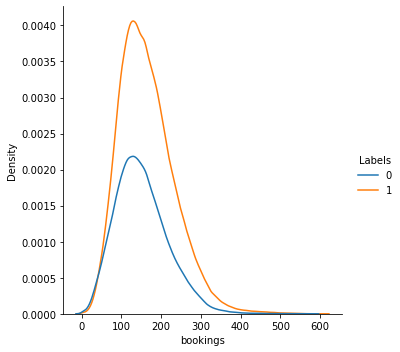

In [115]:
sns.displot(df, x='bookings', hue ="Labels", kind = 'kde')

In [116]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,target,test_size=0.33, random_state=42)


In [117]:
#Creando un objeto Naive Bayes con las condiciones iniciales
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB(var_smoothing = 0.00001)
NB = NB.fit(X_train,y_train)

#Aplicando el modelo a otros datos
resultado=NB.predict(X_test)
print("Resultado de la predicción:\n",resultado)
print("Resultado original:\n",y_test)

#Aplicando el modelo a otros datos
resultados=NB.predict_proba(X_test)
print("Resultado de la predicción:\n",resultados)

Resultado de la predicción:
 [1 1 1 ... 1 0 1]
Resultado original:
 118754    1
557683    1
920464    0
342002    1
795703    0
         ..
437790    1
21087     1
772657    0
276786    0
447843    1
Name: Labels, Length: 329496, dtype: int64
Resultado de la predicción:
 [[0.37459922 0.62540078]
 [0.3443456  0.6556544 ]
 [0.28253138 0.71746862]
 ...
 [0.24510312 0.75489688]
 [0.53242713 0.46757287]
 [0.06812768 0.93187232]]


In [118]:
mt.f1_score(y_test, resultado, pos_label = 1)

0.7581653336952004

In [119]:
print("Clases:\n",df["Labels"].unique())
print("características:\n",df.columns)
print("\nDistribución a prior (P(C)):\n",NB.class_prior_)
print("\nMedias:\n",NB.theta_)
print("\nDesviación estandar (sqrt de sigma):\n",np.sqrt(NB.sigma_))

Clases:
 [1 0]
características:
 Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr',
       'date_departure_int', 'Labels'],
      dtype='object')

Distribución a prior (P(C)):
 [0.34448321 0.65551679]

Medias:
 [[5.82191942e+03 1.47606202e+03 6.30589583e-02 7.38713306e+01
  3.78970801e+00 6.04682991e+00 5.11962543e+01 1.58840665e+01
  4.97485366e+00 9.88843615e-02 2.55039943e+01 2.97408213e+01
  9.55433736e+01 1.72642640e+02 1.50788189e+02 6.07777445e+01
  6.61884826e+01 5.52550868e+00 1.81057661e+01 0.00000000e+00]
 [6.26479195e+03 1.45397872e+03 3.90468046e-02 7.63725512e+01
  3.82651160e+00 6.47302434e+00 6.04029554e+01 1.72695810e+01
  3.22839519e+00 9.47243601e-02 2.59631059e+01 2.51640864e+01
  1.13217431e+02 1.80960970e+02 1.64344623e+02 6.7421814

6264.791945727154 +- 1998.0402261462043


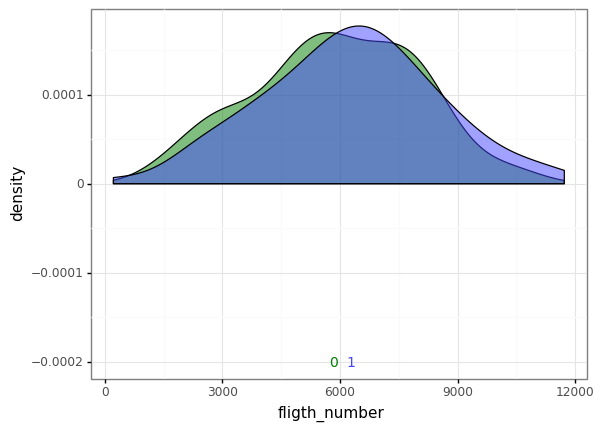

<ggplot: (8763056667534)>

1453.978721851662 +- 1716.6767431360263


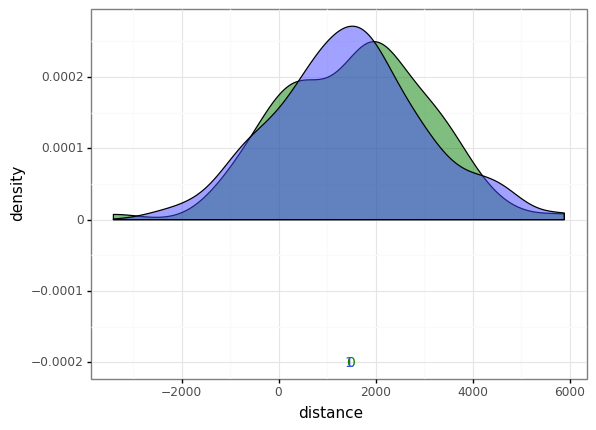

<ggplot: (8763030493946)>

0.03904680462915455 +- 6.500954916573229


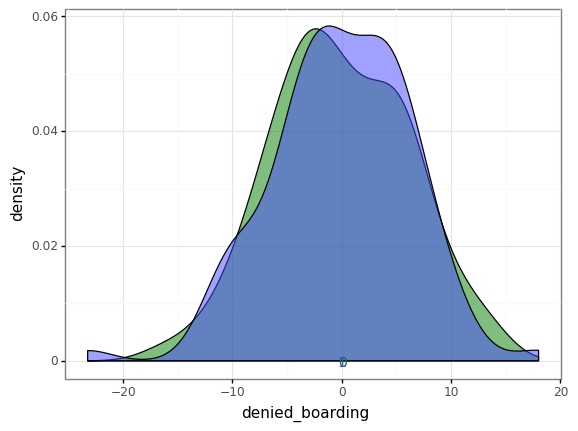

<ggplot: (8763056263319)>

76.37255116584004 +- 46.26584560872045


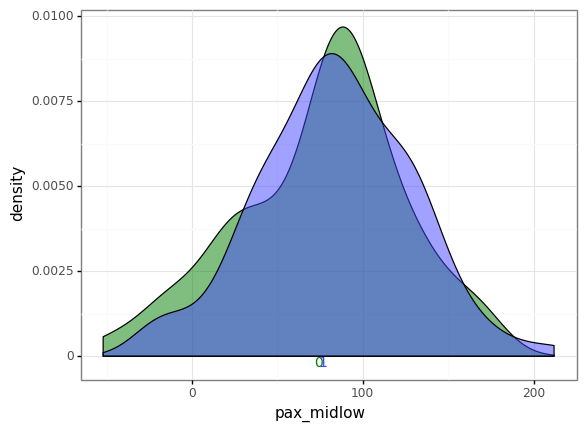

<ggplot: (8763056428216)>

3.8265116013910268 +- 9.605686090021598


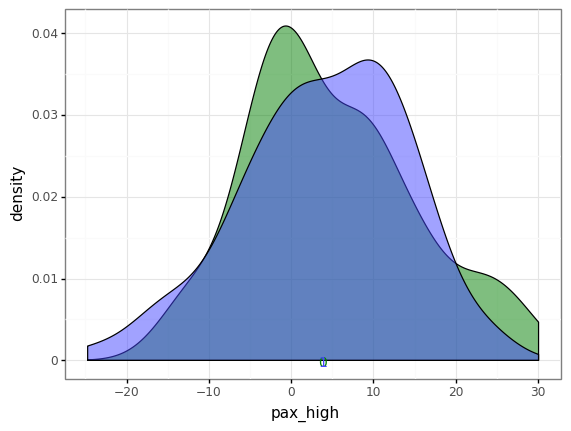

<ggplot: (8763056768464)>

6.4730243429679035 +- 12.129583409497307


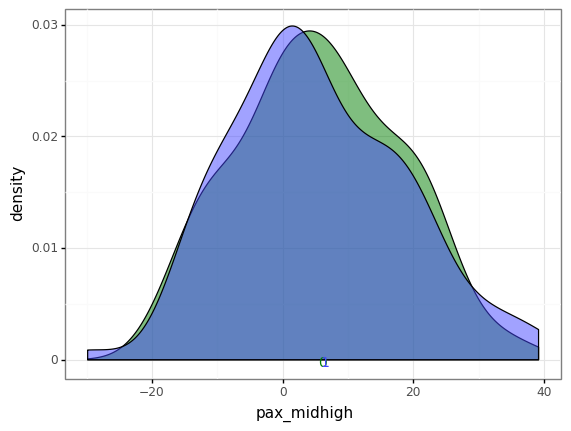

<ggplot: (8763056614373)>

60.40295536172396 +- 39.765787782397986


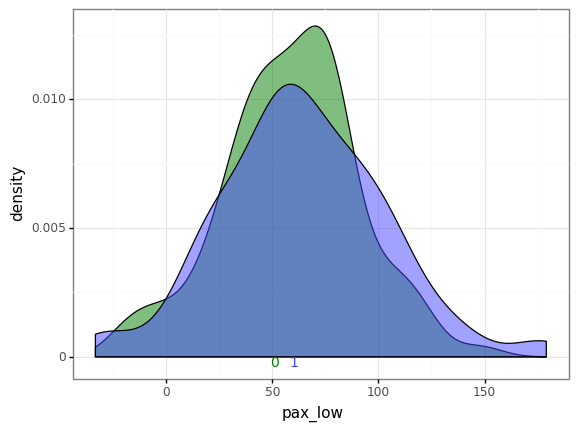

<ggplot: (8763056584988)>

17.269580981700017 +- 15.531186949321727


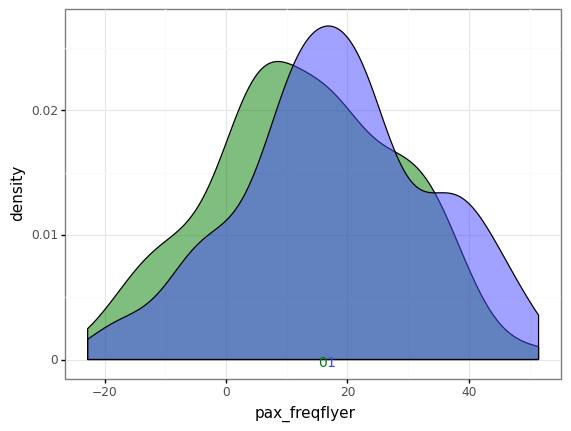

<ggplot: (8763056556578)>

3.228395188415712 +- 12.76169878564068


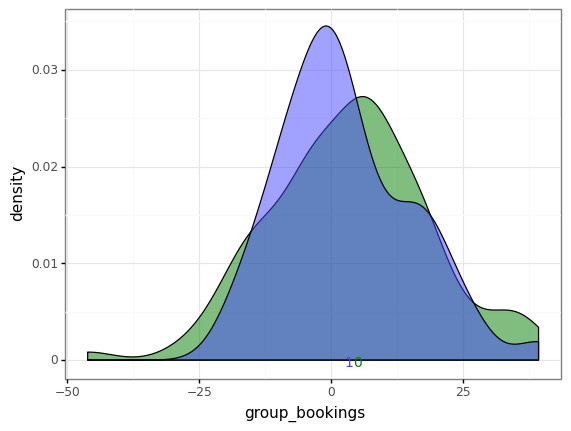

<ggplot: (8763056568242)>

0.09472436007069153 +- 6.4885164386108825


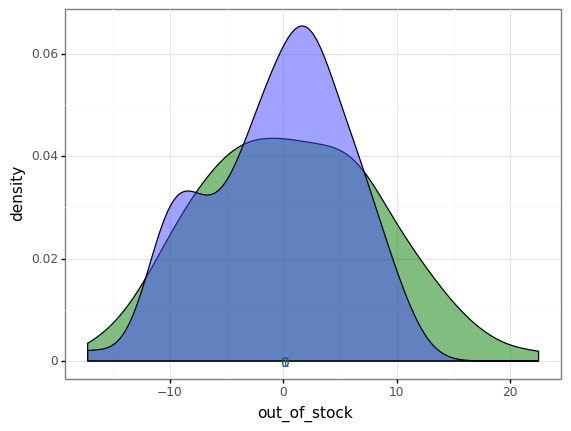

<ggplot: (8763056198497)>

25.9631058662562 +- 32.3480542535991


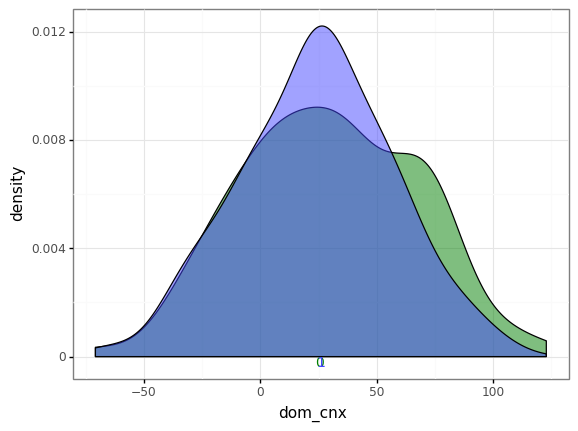

<ggplot: (8763064736699)>

25.16408642608745 +- 43.43767847906425


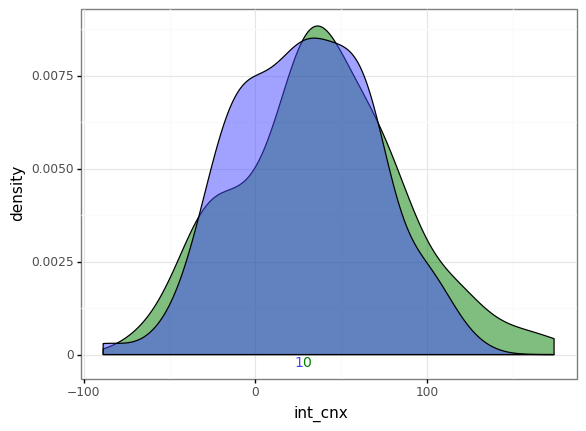

<ggplot: (8763065003096)>

113.2174311612793 +- 66.82568771899948


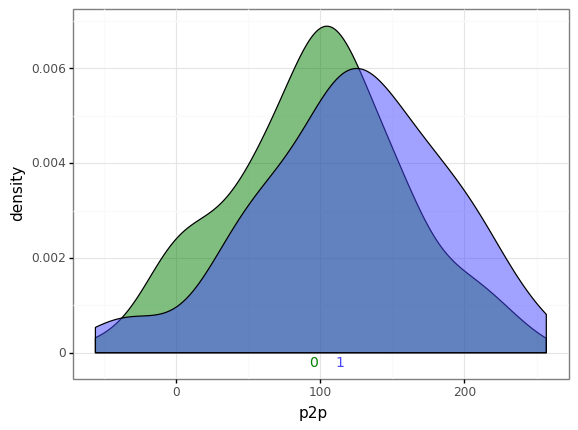

<ggplot: (8763030187240)>

180.96097047624494 +- 34.3813075336774


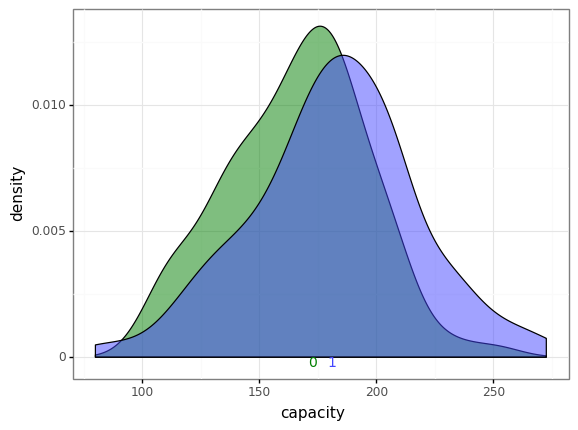

<ggplot: (8763056669251)>

164.34462345362294 +- 69.76576120581018


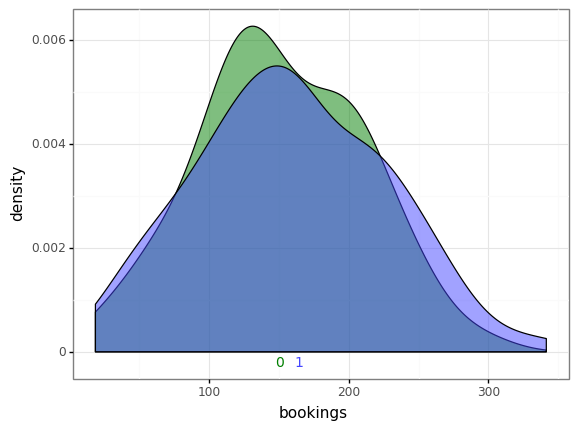

<ggplot: (8763056546919)>

67.42181403568782 +- 42.694400448113086


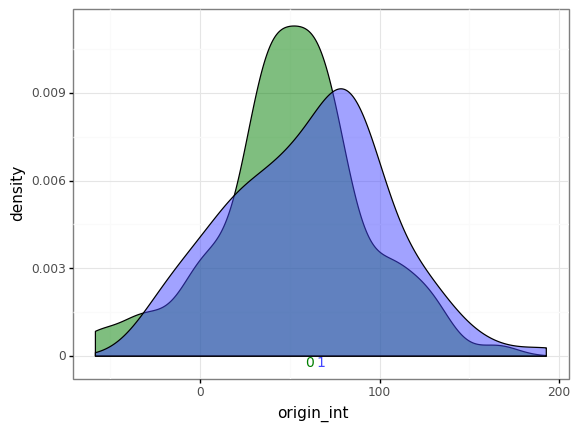

<ggplot: (8763056129609)>

66.87903312239895 +- 43.16898661083005


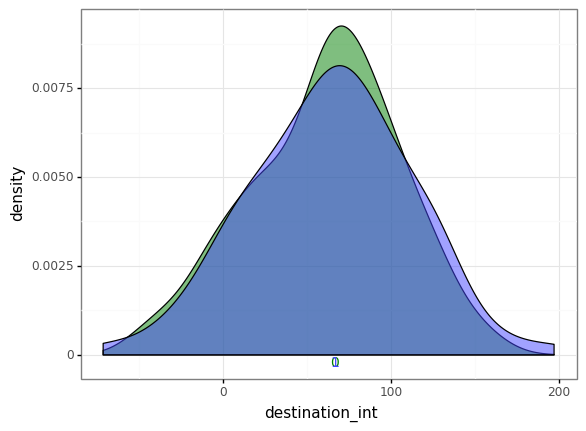

<ggplot: (8763056160690)>

5.492995838321646 +- 7.066014277707919


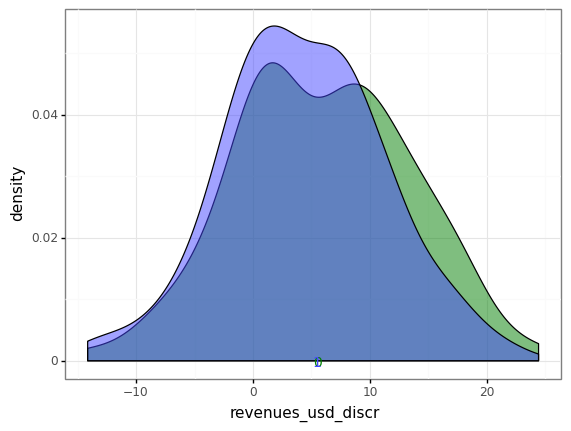

<ggplot: (8763065033069)>

In [120]:
#Visualización de las distribuciones
tempDF=pd.DataFrame(np.zeros((100,2)),columns=["0","1"])
for variable in range(18):
    varSeleccionada=variable
    for i in range(2):
        tempDF.iloc[:,i] = np.random.normal(NB.theta_[i][varSeleccionada], np.sqrt(NB.sigma_[i][varSeleccionada]), 100) 
    print(NB.theta_[1][varSeleccionada], "+-" ,np.sqrt(NB.sigma_[1][varSeleccionada]))
    display(ggplot(tempDF)+theme_bw()+
     geom_density(aes(x="0"),fill="#007F00",alpha=0.5)+
     geom_density(aes(x="1"),fill="#4446FF",alpha=0.5)+
     annotate("text",x=NB.theta_[0][varSeleccionada],y=-0.0002,label=0,color="#007F00",size=10)+
     annotate("text",x=NB.theta_[1][varSeleccionada],y=-0.0002,label=1,color="#4446FF",size=10)+
     labs(y="density",x=df.columns[varSeleccionada])
    )